# Проект: HR аналитика

## Фабула проекта

**Заказчик:** «Работа с заботой» - компания консалтер в области управления персоналом

**Данные:** Характеристики сотрудников компании, информация об удовлетворености работой в компании.

**Задачи проекта:**
1. Задача: построить модель предсказания уровня удовлетворённости сотрудника.
2. Задача: построить модель предсказания риска увольнения сотрудника из компании.

**План проекта:**
1. Построение модели, которая предсказывает уровень удовлетворённости сотрудника в компании:
       1.1. Загрузка данных
       1.2. Предобработка данных
       1.3. Исследовательский анализ данных
       1.4. Подготовка данных
       1.5. Обучение моделей
       1.6. Выводы по итогу задачи
2. Построение модели, которая предсказывает увольнение сотрудника из компании
       2.1. Загрузка данных
       2.2. Предобработка данных
       2.3. Исследовательский анализ данных
       2.4. Добавление нового входного признака
       2.5. Подготовка данных
       2.6. Обучение модели
       2.7. Выводы по итогу задачи
3. Общий вывод

### Паспорт данных  

**Файлы с данными:**
 - Тренировочная выборка: train_job_satisfaction_rate.csv
 - Входные признаки тестовой выборки: test_features.csv
 - Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

**Описание данных:**
 * **id** — уникальный идентификатор сотрудника;
 * **dept** — отдел, в котором работает сотрудник;
 * **level** — уровень занимаемой должности;
 * **workload** — уровень загруженности сотрудника;
 * **employment_years** — длительность работы в компании (в годах) - дискретный признак;
 * **last_year_promo** — показывает, было ли повышение за последний год;
 * **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
 * **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
 * **salary** — ежемесячная зарплата сотрудника;
 * **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак;
 * **quit** — увольнение сотрудника из компании

## Задача: построить модель предсказания уровня удовлетворённости сотрудника.

### Загрузка данных

#### Загрузка библиотек и данных

In [ ]:
pip list

Package                           Version
--------------------------------- -------------------
absl-py                           1.2.0
alembic                           1.6.5
anyio                             3.2.1
argon2-cffi                       20.1.0
astunparse                        1.6.3
async-generator                   1.10
attrs                             21.2.0
Babel                             2.9.1
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.9.3
bleach                            3.3.0
blinker                           1.4
blis                              0.7.8
branca                            0.5.0
brotlipy                          0.7.0
cachetools                        5.2.0
catalogue                         2.0.8
catboost                          1.0.3
certifi                           2022.6.15
certipy                           0.1.3
cffi                              1.14.5
chardet             

In [ ]:
# установим недостающиие пакеты
!pip install phik -q
!pip install shap -q
!pip install --upgrade scikit-learn -q!
!pip install --upgrade matplotlib==3.4.3 -q


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -!


In [ ]:
# ипортируем необходимые для работы библиотеки
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import phik
from phik import phik_matrix

import requests

import seaborn as sns
import shap

from sklearn.dummy import (DummyClassifier,
                           DummyRegressor)
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.metrics import (make_scorer,
                             roc_auc_score)
from sklearn.model_selection import (RandomizedSearchCV)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   MinMaxScaler,
                                   RobustScaler,
                                   StandardScaler
                                  )

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from scipy.stats import ttest_ind

In [ ]:
# зададим значение константы
RANDOM_STATE = 42

In [ ]:
# уберем максимальную ширину колонки
pd.set_option('display.max_colwidth', None)

In [ ]:
# загрузим в датафрейм тренировочную выборку
pth1 = '/datasets/train_job_satisfaction_rate.csv'
pth2 = 'https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv'

if os.path.exists(pth1):
    train_job = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            train_job = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

In [ ]:
# загрузим в датафрейм входные признаки тестовой выборки
pth1 = '/datasets/test_features.csv'
pth2 = 'https://code.s3.yandex.net/datasets/test_features.csv'

if os.path.exists(pth1):
    test_feature = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            test_feature = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

In [ ]:
# загрузим в датафрейм целевой признак тестовой выборки
pth1 = '/datasets/test_target_job_satisfaction_rate.csv'
pth2 = 'https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv'

if os.path.exists(pth1):
    test_target = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            test_target = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

#### Изучение загруженных данных

In [ ]:
# используем ранее написанную функцию для изучения основной информации о датасетах
def data_info(data):
    display(data.info()) # вывод информации о датафрейме
    print('=' * 20)
    display(data.head()) # вывод верхнийх 5 строк датафрейма
    display(data.sample(10)) # вывод случайных 10 строк датафрейма
    display(data.tail()) # вывод нижних 5 строк датафрейма
    display(data.describe().T) # вывод статистических показателей числовых значений датафрейма
    print('Количество явных дубликатов: ', data.duplicated().sum()) # определение количества явных дубликатов строк
    print('Строки дубликаты:\n', data[data.duplicated()]) # вывод строк дубликатов, для их проверки
    print('=' * 20)
    print('Количество пропусков:\n', data.isna().sum()) # Вывод количества пропусков в датафрейме
    print('Доля пропусков в датафрейме:') # вывод информации о доле пропусков в датафрейме
    col = data.columns.tolist() # введем переменную со списком названий столбцов
    # циклом выведем долю пропусков в каждом столбце
    for a in col:
        print(f'В столбце {a} доля пропусков: {(data[a].isnull().sum() / len(data[a])*100).round(3)}%')
    print('=' * 20)
    print('Список уникальных значений в датафрейме:')
    # выведем список уникальных строковых значений для определения неявных дубликатов
    for b in data.select_dtypes('object').columns: # задаем поиск только по столбцам со сторовыми данными
        print(f'{b} : {data[b].unique()}')

In [ ]:
# выведем на экран информацию о тренировочной выборке
data_info(train_job)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
565,683278,sales,middle,low,5,no,no,5,24000,0.88
1290,114587,marketing,middle,low,6,no,no,4,26400,0.79
91,641867,technology,junior,high,1,no,no,1,44400,0.36
3806,495920,purchasing,middle,medium,7,no,no,1,37200,0.38
2815,151279,marketing,junior,low,3,no,no,3,13200,0.29
2182,760562,marketing,junior,medium,2,no,no,3,24000,0.37
1339,504437,technology,junior,medium,2,no,no,4,31200,0.75
3454,194955,sales,junior,medium,2,no,no,4,21600,0.66
1398,115447,technology,middle,high,6,no,no,3,57600,0.44
2543,967124,sales,middle,medium,3,no,no,4,43200,0.65


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48
3999,338347,technology,middle,medium,5,no,yes,1,44400,0.18


,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: []
Количество пропусков:
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце dept доля пропусков: 0.15%
В столбце level доля пропусков: 0.1%
В столбце workload доля пропусков: 0.0%
В столбце employment_years доля пропусков: 0.0%
В столбце last_year_promo доля пропусков: 0.0%
В столбце last_year_violations доля пропусков: 0.0%
В столбце supervisor_evaluation доля пропусков: 0.0%
В столбце salary доля пропусков: 0.0%
В столбце job_satisfaction_rate доля пропусков: 0.0%
С

In [ ]:
# выведем на экран информацию о тестовой выборке
data_info(test_feature)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1121,594345,sales,junior,medium,1,no,no,1,20400
663,261143,marketing,junior,medium,1,no,no,2,24000
47,882583,hr,middle,low,3,no,no,3,30000
629,748258,sales,junior,low,2,no,no,3,12000
875,450088,sales,junior,medium,2,no,no,3,26400
1639,366272,sales,junior,medium,1,no,no,5,21600
209,521252,sales,middle,low,7,no,no,5,19200
118,882935,sales,junior,low,1,no,yes,3,15600
1044,744352,sales,sinior,medium,9,no,no,3,50400
1994,497976,technology,middle,medium,3,no,no,4,52800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: []
Количество пропусков:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце dept доля пропусков: 0.1%
В столбце level доля пропусков: 0.05%
В столбце workload доля пропусков: 0.0%
В столбце employment_years доля пропусков: 0.0%
В столбце last_year_promo доля пропусков: 0.0%
В столбце last_year_violations доля пропусков: 0.0%
В столбце supervisor_evaluation доля пропусков: 0.0%
В столбце salary доля пропусков: 0.0%
Список уникальных значений в датафрейме:
dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan 

In [ ]:
# выведем на экран информацию о выборке с целевым признаком
data_info(test_target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,job_satisfaction_rate
1608,847789,0.28
1947,307112,0.81
1060,788110,0.47
837,258615,0.32
1185,390369,0.42
957,533604,0.12
1331,953956,0.75
763,212048,0.17
322,593079,0.79
8,649052,0.14


,id,job_satisfaction_rate
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26
1999,648995,0.62


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, job_satisfaction_rate]
Index: []
Количество пропусков:
 id                       0
job_satisfaction_rate    0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце job_satisfaction_rate доля пропусков: 0.0%
Список уникальных значений в датафрейме:


#### Выводы по блоку

**train_job**
При изучения данного датафрейма видим, что:
 - датафрейм состоит из 4000 записей в 10 колонках-признаков
 - качественные данные содержатся в следующих колонках: dept - отдел в котром работает сотрудник, level -  уровень занимаемой должности, workload - уровень загруженности сотрудника, last_year_promo - было ли повышение за последний год, last_year_violations - нарушал ли трудовой договор в последний год. Из них: last_year_promo, last_year_violations содержат бинарные данные;
 - колнка "id" не смотря на числовые значения фактически сожержит категориальные данные - PII;
 - явных дубликатов в данных нет;
 - есть пропуски в колонках dept и level, требуется детальное изучение причин этих пропусков;
 - есть ошибка написания грейда квалификации - sinior вместо senior.

**test_feature**
 При изучении данного датафрейма видим, что:
 - датафрейм состоит из 2000 записей  (соотношение теста к трейну 1/3 к 2/3) в 9 колонках (9 колонок входных признаков, 10я - целевой признак)
 - аналогичный набор колонок с качественными данными
 - колонка "id" не смотря на числовые значения фактически сожержит категориальные данные - PII;
 - явных дубликатов в данных нет;
 - снова есть пропуски в колонках dept и level, требуется детальное изучение причин этих пропусков.
 - видим неявные пропуски в виде пустого значения в колонках dept и workload
 - есть ошибка написания грейда квалификации - sinior вместо senior;
 - в целом средние значения, как и часть минимальных и максимальных в тестовой выборке отличаются от тренировочной.

**test_target**
 При изучении данного датафрейма видим, что:
 - датафрейм состояит из 2000 записей в 2 колонках (id и целевой признак)
 - дубликатов, как и пропусков в данных нет

### Предобработка данных

#### Исправление ошибок

In [ ]:
# исправим ошибку в грейде
train_job['level'].replace({'sinior': 'senior'}, inplace=True)
test_feature['level'].replace({'sinior': 'senior'}, inplace=True)

In [ ]:
# исправим пустое написание на пропуск nan
test_feature['dept'].replace({' ': np.nan}, inplace=True)
test_feature['workload'].replace({' ': np.nan}, inplace=True)

In [ ]:
# проверим возможноe перечесение id в тестовой и тренировочной выборках
len(train_job[train_job['id'].isin(test_feature['id'].unique())])

0

In [ ]:
# проверим возможноe перечесение id в  тренировочной выборке по целевому признаку
len(train_job[train_job['id'].isin(test_target['id'].unique())])

0

In [ ]:
# сделаем id индексами и отсортируем
train_job = train_job.sort_values(by=['id']).set_index('id')
test_feature = test_feature.sort_values(by=['id']).set_index('id')
test_target = test_target.sort_values(by=['id']).set_index('id')

#### Исправление пропусков

In [ ]:
# выведем все строки с пропусками в тренировочном датасете
train_job[train_job['dept'].isnull() | train_job['level'].isnull()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
135043,sales,NaN,medium,1,no,no,3,26400,0.30
168668,NaN,junior,low,3,no,no,4,18000,0.88
416327,sales,NaN,low,1,no,no,5,18000,0.73
475114,NaN,junior,high,4,no,no,4,31200,0.63
497243,NaN,junior,medium,1,no,no,3,26400,0.28
631073,sales,NaN,medium,1,no,no,4,27600,0.66
641150,NaN,junior,low,3,no,yes,4,12000,0.54
694746,NaN,junior,medium,5,no,no,4,21600,0.62
814624,NaN,junior,medium,3,no,no,4,24000,0.88


Видим, что явной закономерности в пропусках нет, кроме того, что они касаюся части джунов и части сейлзов

In [ ]:
# выведем все строки с пропусками в тестовом датасете
test_feature[test_feature['dept'].isnull() | test_feature['level'].isnull() | test_feature['workload'].isnull()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
471990,sales,NaN,low,1,no,no,3,12000
590867,marketing,junior,NaN,4,no,no,4,28800
609865,NaN,junior,medium,1,no,no,1,20400
822186,NaN,middle,medium,3,no,no,4,38400
832342,NaN,junior,medium,1,no,no,4,28800


Видим, что тут тоже нет явной закономерности в причинах пропусков поэтому все пропуски в дальнейшем заполним в пайплайне с помощью SimpleImputer

#### Выводы по блоку

По итогу предобработки данных были произведены следующие операции:
 - исправлены ошибки в написании грейда senior
 - пустые значения ' ' заменены на пропуски nan
 - проведена проверка корректности разделения тестовой и тренировочной выборок на пересечения по id
 - id переведены в индексы и отсортированы
 - по итогу изучения пропусков принято решение их заполнить в паплайне с помощью SimpleImputer

### Исследовательский анализ данных

Для исследовательского анализа используем ранее написанные функции по построению графиков и лист со списком названий колонок содержащих дискретные значения. Но поскольку у нас здесь и тренировочная и тестовая выборки, то перепишем функцию, чтобы можно было сравнивать и тренировочную и тестовую выборки.

In [ ]:
# запишем лист со списком колонок с дискретными значениями
discrete_list = ['employment_years',
                 'supervisor_evaluation']

In [ ]:
# функция построения графиков для количественных данных
# функция предусматривае сравнение двух фреймов
def quant_plot(graf_data1, data1_title, graf_data2, data2_title, subtitle, xlabel, ylabel):

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    fig.suptitle(subtitle)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    plt.subplot (2, 2, 1)
    sns.histplot(graf_data2, kde=True, bins=50)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(data1_title)

    plt.subplot (2, 2, 2)
    sns.histplot(graf_data2, kde=True, bins=50)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(data2_title)

    plt.subplot (2, 2, 3)
    sns.boxplot(x=graf_data1)
    plt.xlabel(xlabel)
    plt.title(data1_title)

    plt.subplot (2, 2, 4)
    sns.boxplot(x=graf_data2)
    plt.xlabel(xlabel)
    plt.title(data2_title)

    plt.show()

In [ ]:
# функция построения графиков для дискретных признаков
# функция предусматривае сравнение двух фреймов
def disc_plot(graf_data1, data1_title, graf_data2, data2_title, col, subtitle, xlabel, ylabel):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    fig.suptitle(subtitle)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    plt.subplot (2, 2, 1)
    sns.countplot(data=graf_data1, x=col)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(data1_title)

    plt.subplot (2, 2, 2)
    sns.countplot(data=graf_data2, x=col)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(data2_title)

    plt.show()

In [ ]:
# функция построения графиков для качественных данных
# функция предусматривае сравнение двух фреймов
def cat_plot(data1, data1_title, data2, data2_title, subtitle):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    fig.suptitle(subtitle)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    plt.subplot (2, 2, 1)
    plt.pie(
        data1.value_counts(),
        labels=data1.unique(),
        autopct='%1.1f%%')
    plt.grid()
    plt.title(data1_title)

    plt.subplot (2, 2, 2)
    plt.pie(
        data2.value_counts(),
        labels=data2.unique(),
        autopct='%1.1f%%')
    plt.grid()
    plt.title(data2_title)

    plt.show()

#### Статистический анализ

In [ ]:
# выведем на экран статистическую информацию тренировочной выборке
train_job.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


 - Видим, что у нас всего 4 количественных признака, из которых 1 целевой и три входных. Признаки employment_years (стаж работы в компании) и supervisor_evaluation (оценка руководителем) дискретные.
 - По стажу работы, средний стаж работы сотрудников составляет 3.7 лет, медианный 3 года, значение третьего кварти ля 6 лет, при этом максимальное значение - 10 лет. Это значит что основная масса сотрудников имеет стаж до 6 лет. И это нормальные показатели, которые говорят об отсутствии высокой кадровой текучки, так как набор кадров идет постепенно, с ростом компании, так что тот факт, что сотрудников с солидным стажем единицы, это нормально.
 - По оценке руководителем, видим, что среднее значение у нас 3.4, то есть в среднем у сотрудников оценки выше средних, хоть и близки к значению 3. Но это может быть, в том числе, следствием большого количества джунов в компании.
 - Средняя заработная плата в компании составляет 33 926 рублей, медианное значение 30 000 рублей, то есть ниже среднего. Такое смещение свидетельствует об искажении картины за счет высоких зарплат части сотрудников при этом види, что максимальная заработная плата - 98 400 рублей, что более чем в три раза превышает медианную зарплату и в три раза превышает среднюю.
 - Уровень удовлетворенности работой у сотрудников в среднем составляет 0,53 балла, при медианном 0,56 а это как раз говорит о том, что наоборот смещение вызвано крайне низкими оценками части сотруников. И действительно минимальное значние по оценке 0,03 балла. Возможно это аномалия, но это будет видно при графическом анализе.

In [ ]:
# выведем на экран статистическую информацию тестовой выборке
test_feature.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


В тестовой выборке мы имеем дело только с входящими признаками, и види, что тут:
 - среднее значение стажа работы несколько меньше чем в тренировочной выборке, но в целом значения квартилей соответствуют тренировочной выборке, кроме значения первого квартиля, которое в тренировочной выборке соответствует минимальному значению.
 - по оценке работодателя среднее значение несколько выше, чем в тренировочной выборке, но значения первого квартиля медианы и третьего квартиля соответствуют.
 - по уровню заработной платы, среднее значение превышает аналогичное в тренировочной выборке - 34 066 рублей, а максимальное значение меньше - 96 000 рублей, то есть в выборке больше сотрудников с заработной платой выше медианного, хотя значения 1, 2 и 3 квартилей аналогичны тренировочной выборке

In [ ]:
# выведем на экран статистическую информацию о выборке сцелевым признаком
test_target.describe().T

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.54878,0.22011,0.03,0.38,0.58,0.72,1.0


Уровень удовлетворенности в тестовой выборке тоже отличается от тренировочной: срелнее значнеи выше, да и значения 1 2 и 3 квартилей несколько выше

Все это свидетельствует о небольшой несбалансированнойсти тренировочной и тестовых выборок, что, при обучении моделей и построении прогнозов будет давать некотрую погрешность прогноза.

#### Графический анализ

In [ ]:
# запишем переменную со словарем имен колонок и их подписям в графиках
subs = {'dept': 'отделу работы сотрудников',
        'level': 'грейду квалификации',
        'workload': 'уровню загруженности',
        'employment_years': 'стажу работы в компании',
        'last_year_promo': 'факту повышения в последний год',
        'last_year_violations': 'фактам нарушений трудового договора в последний год',
        'supervisor_evaluation': 'оценке работника руководителем',
        'salary': 'размеру заработной платы',
        'job_satisfaction_rate': 'уровню удовлетворенности сотрудника',
       }

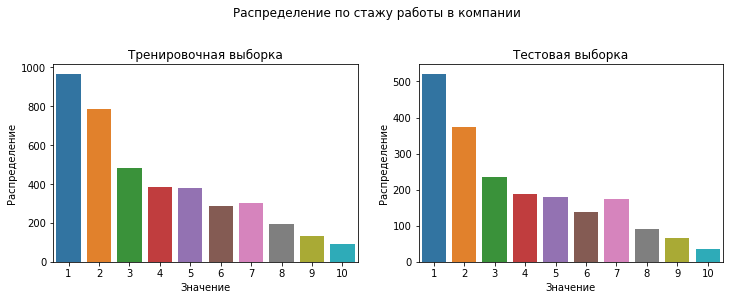

____________________________________________________________________________________________________


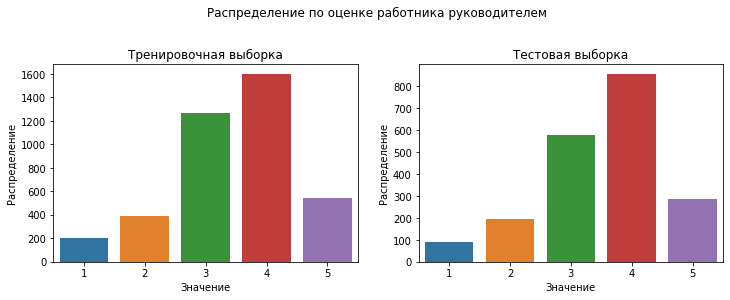

____________________________________________________________________________________________________


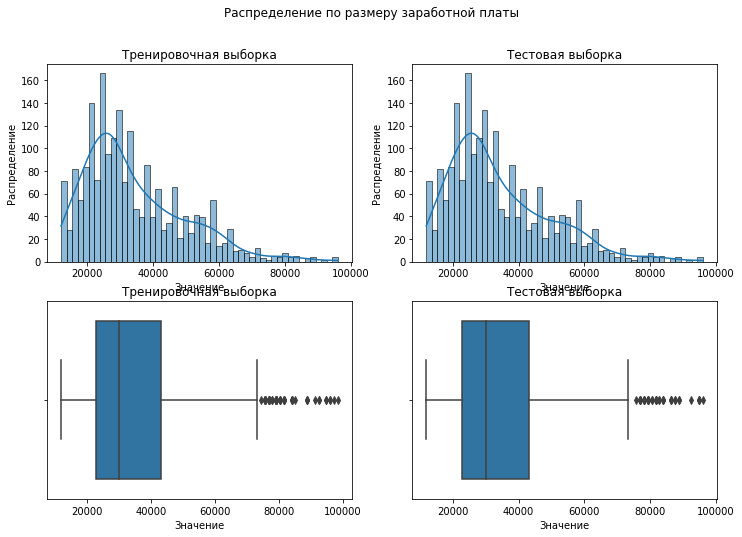

____________________________________________________________________________________________________


In [ ]:
# запустим цикл построения графиков для количественных данных
for p in train_job.drop(['job_satisfaction_rate'],axis=1).select_dtypes('number').columns:
    if p in discrete_list:
        disc_plot(train_job,
                  'Тренировочная выборка',
                  test_feature,
                  'Тестовая выборка',
                  p,
                  f'Распределение по {subs.get(p)}',
                  'Значение',
                  'Распределение')
    else:
        quant_plot(train_job[p],
                   'Тренировочная выборка',
                   test_feature[p],
                   'Тестовая выборка',
                   f'Распределение по {subs.get(p)}',
                   'Значение',
                   'Распределение')
    print ('_'*100)

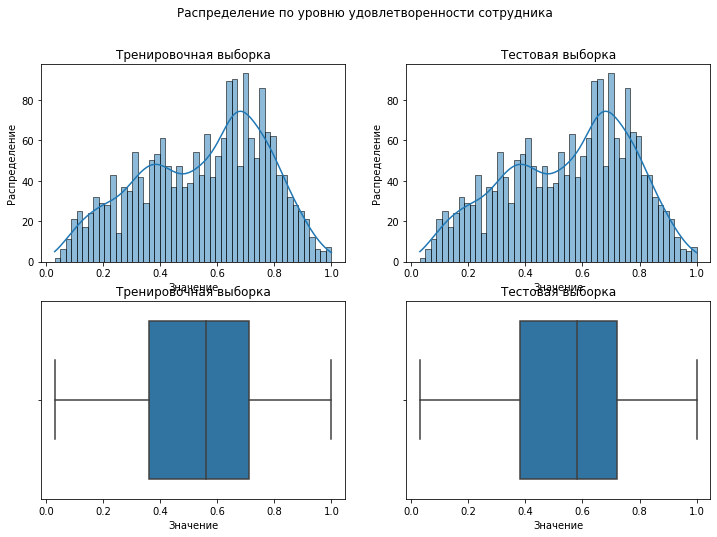

In [ ]:
# выведем график для целевого признака
s = 'job_satisfaction_rate' # заведем переменную с именем колонки целевого признака
quant_plot(train_job[s],
           'Тренировочная выборка',
           test_target[s],
           'Тестовая выборка',
           f'Распределение по {subs.get(s)}',
           'Значение',
           'Распределение')

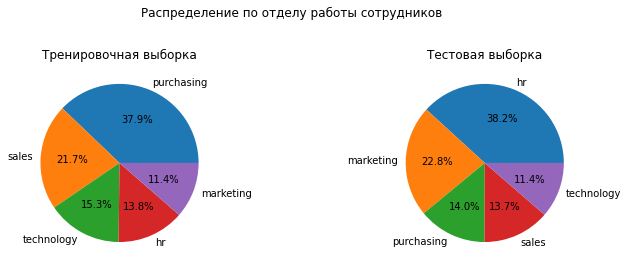

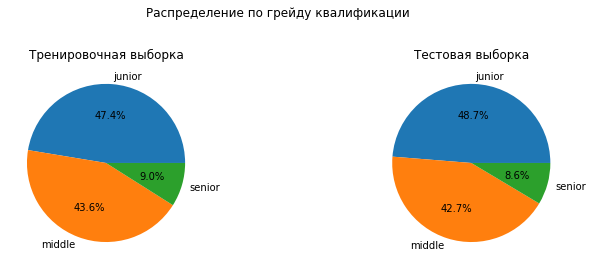

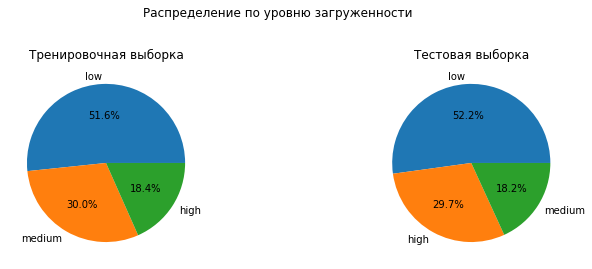

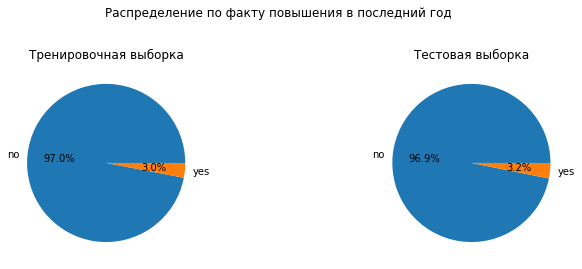

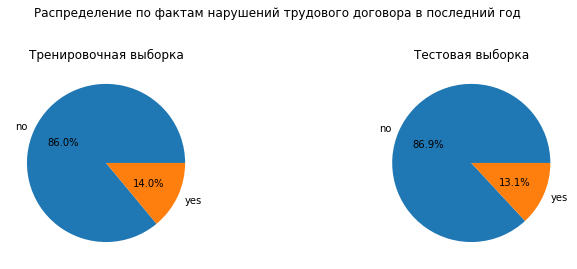

In [ ]:
# запустим цикл построения графиков для качественных данных
for p in train_job.select_dtypes('object').columns:
    cat_plot(train_job[p].dropna(),
             'Тренировочная выборка',
             test_feature[p].dropna(),
             'Тестовая выборка',
             f'Распределение по {subs.get(p)}')

При оценке количественных данных, видим, что:
 - распределение по стажу работы в компании в целом нисходящее от 1 до 10, но это не является показателем текучки кадров, такое распределение является нормальным, по мере роста компании. Однако мы видим небольшой дисбаланс между показателями тренировочной и тестовой выборок;
  - распределение по оценке руководителем в основной массе варьируется между оценками 3 и 4, с пиком на оценке 4 и картина в тренировочной выручке немного отличается от тестовой в значениях 3.
  - по размеру заработной платы распределения в тренировочной и тестовой выборках идентичные, незначительне отличия есть только в выбросах, что не сильно критично.
  - по уровленю удовлетворенности работой распределение практически идентичное, неравномерное, с пиками на значениях 0,65, 0.7, 0,75, однако видим смещение плотности по графику boxplot в тестовой выборке по сравнению с тренировочной.
  
При оценке качественных данных, видим, что:
 - картина распределения по отделам работы сотрудников в целом кажется похожим, но по содержанию сильно отличается:
     - в тренировочной выборке наибольшая доля сотрудников из отдела продаж, а в тестовой из отдела маркетинга
     - третье место в тренировочной выборке с долей 15.3% занимает технологический блок, в тестовой - продажи
     - наименьшую долю в тренировочной выборке занимает маркетинг, а в тестовой технологический блок
 - распределение по грейду сотрудников имеет небольшие отличия в целом, мы видим, что основную массу занимают джуны ( ~48%)и мидлы ( ~43%)
 - по уровню загруженности, в целом основная масса сотрудников имеет среднюю загруженность, но при этом мы снова видим дисбаланс классов в тренировочной и тестовой выборках: в тренировочной выборке 30% сотрудников имеют высокую нагрузку, в то время как в тестовой эту же долю занимают сотрудники с низкой нагрузкой.
 - распределение по фактам повышения сотрудников в тренировочной и тестовой выборках почти идентичны - в обеих выборках ~97% занимает доля сотрудников не нарушавших трудовой договор
 - распределение по фактам нарушения трудового договора в последний год тоже почти идентичное: 86-87% сотрудников в последний год не допускали нарушения трудового договора

#### Корелляционный анализ

Для корректности корреляционного анализа выделим лист с перечнем колонок с непрерывными признаками. Такими признаками будут: размер заработной платы, и уровень удовлетворенности работой

In [ ]:
# заведем переменную со списком колонок содержащих непрерывные признаки
int_cols = ['salary', 'job_satisfaction_rate']

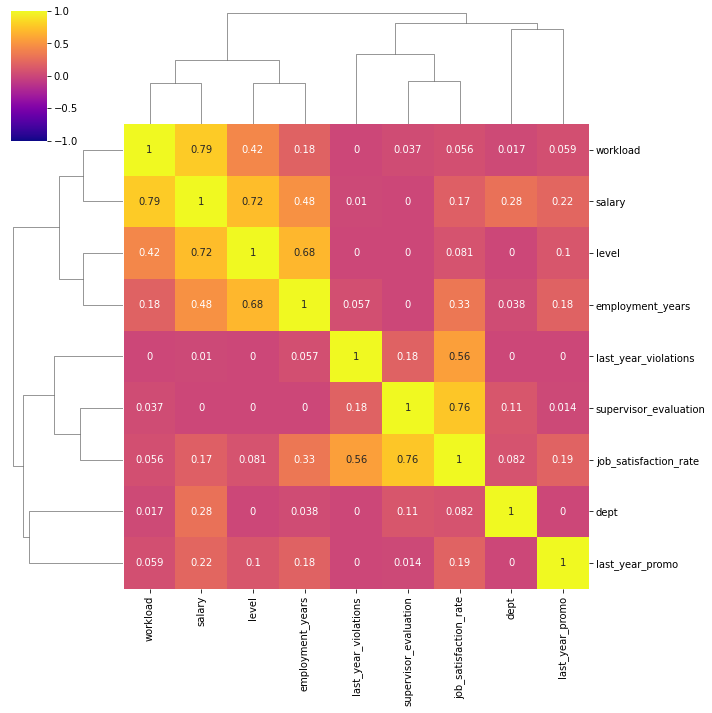

In [ ]:
# построим кластерную матрицу по итоговой таблице phik_matrix()
sns.clustermap(
    train_job.phik_matrix(interval_cols=int_cols),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='plasma')

Видим, что мультиколлинеарности между признаками нет - максимальное значение корреляции 0,79.
При этом, видно, что наибольшее влияние на целевой признак уровень удовлетворенности работой имеют признаки:
 - 'supervisor_evaluation' - оценка работника руководителем - 0,76. Иными словами, чем чаще работник получает от своего руководителя положительную обратную связь о своей работе, тем выше его уровень удовлетворенности работой. И наоборот - отрицательная обратная связь и критика работы снижают уровень удовлетворенность работой.
 - 'last_year_violations - факты нарушения трудового договора в послелний год - 0,56. Но тут скорее обратная зависимость - чем выше уровень удовлетворенности, тем ниже риски нарушения работников трудового договора. И наоборот, чем ниж уровень удовлетворенности, тем выше риски нарушения трудового договора.

Любопытно, что размер заработной платы имеет очень низкое влияние на уровень удовлетворенности - 0,17 как и факт повышения на работе - 0,19

Тем не менее, дополнительно построим матрицу корреляциии и для тестовой выборки, чтобы исключить риски мультиколлинеарности признаков и там.

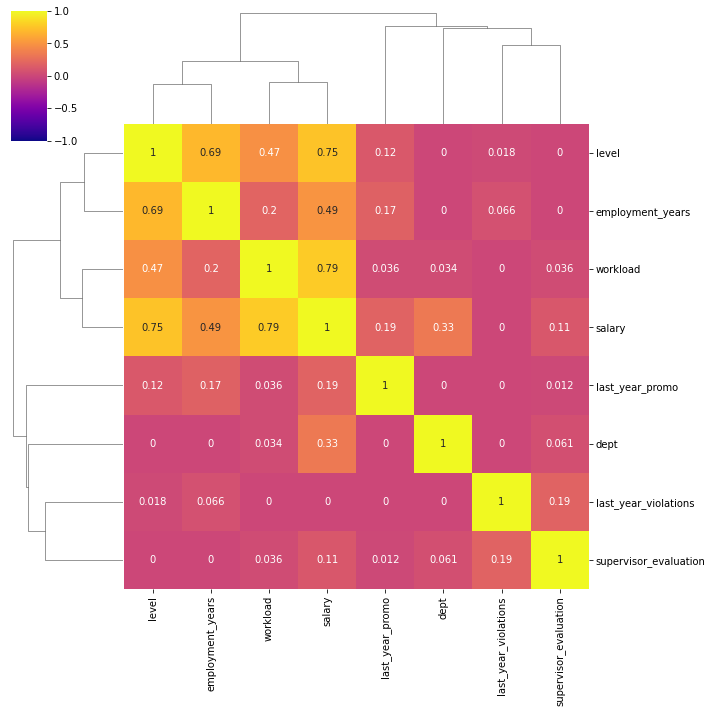

In [ ]:
# построим кластерную матрицу корреляции для тестовой выборки
sns.clustermap(
    test_feature.phik_matrix(interval_cols=int_cols),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='plasma')

Также видим осутствие мультиколлинеарности между признаками и в тестовой выборке без целевого признака.

#### Выводы по блоку

В процессе исследовательского анализа выбросов серьезно влияющих на обучене моделей мы не выявили, однако выявили несоответствие пропорций входных признаков в тренировочной выборке и в тестовой по отделам работы сотрудников и уровню их трудовой загрузки.
Кроме того при корреляционном анализе выявили отсутствие мультиколлинеарности между входными признаками и выявили признаки оказывающие наибольшее влияние на целевой признак

### Подготовка данных

#### Удаление дубликатов

После перевода id  в индексы, у нас могли появиться дубликаты. ДА фактически это данные разных людей и в теории подные дубликаты могли иметь место, но они будут мешать обучению модели, так что их лучше удалить.

In [ ]:
# удаоим дубликаты из тренировочной выборки для обучения
train_job = train_job.drop_duplicates()
train_job.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


После удаления дубликатов у нас сократилось количество строк в тренировочной выборке до 3755

#### Подготовка данных

У нас уже имеются выборки с входными признаками, как тренирвочные, так и тестовые, а также выборк с целевым признаком. На их основе создадим выборки для обучения.

In [ ]:
# запишем на основе вводных датафреймов выборки для обучения
X_train_1 = train_job.drop('job_satisfaction_rate', axis=1)
y_train_1 = train_job['job_satisfaction_rate']
X_test_1 = test_feature
y_test_1 = test_target['job_satisfaction_rate']

In [ ]:
# запишем названия колонок разных типов данных для кодирования
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [ ]:
# постоим пайплан для кодирования категориальных признаков
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [ ]:
# построим пайплайн для коирования порядковых данных
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

In [ ]:
# запишем препроцессор
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# построим финальный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

#### Выводы по блоку

В процессе подготовки данных для обучения, были проведены следующие операции:
 - Из тренировочной выборки веделен целевой признак, сама трерировочная выборка от него очищена, для обучения первой модели в отдельные переменные выделены тренировочные и тестовые показатели
 - собраны пайплайны для кодирования разных типов данных:
      - категорийные данные из колонок 'dept' - отдел работы сотрудника 'last_year_promo' - факт повышения в последний год и 'last_year_violations' - факт нарушения трудового договора в последний год, кодированы с помощью кодировщика OneHotEncoder, пропуски заполнены с помощью SimpleImputer наиболее популярными значениями;
      - порядковые категорийныйе данные из колонок 'level' - грейд работника и 'workload' - рабочая нагрузка работника, кодированы с помощью кодировщика OrdinalEncoder, пропуски также заполнены с помощью SimpleImputer наиболее популярным значениями.
 - числовые значения масштабированы с помощью RobustScaler робастными из-за наличия выбросов;
 - проведена трансформация тренировочной и тестовой выборок

### Обучение модели

По условиям задачи мы должны выбор сделать на основе метрики SMAPE. Подготовим для этого функцию для расчета метрики.

In [ ]:
# создадим функцию для расчета метрики SMAPE
def smape(A, F):
    denominator = (np.abs(A) + np.abs(F)) / 2.0
    diff = np.abs(A - F) / denominator
    return 100 * np.mean(diff)

In [ ]:
# запишем метрику на основе SMAPE
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [ ]:
# запишем сетку параметров для перебора
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 30),
        'models__min_samples_leaf': range(1, 30),
        'models__min_samples_split': range(2, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    }
]

In [ ]:
# обучим модель предсказания
model = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=50,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
# выведем лучшую модель и метрику на кросс-валидации
model.fit(X_train_1, y_train_1)
print('Лучшая модель и её параметры:\n\n', model.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', model.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [ ]:
# выведем значение метрики SMAPE
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test_1, model.predict(X_test_1)),1)}%')

Метрика SMAPE лучшей модели на тестовой выборке: 13.6%


In [ ]:
# проверим модель на адекватность
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train_1, y_train_1)
print(f'Метрика SMAPE модели DummyRegressor на тестовой выборке: {round(smape(y_test_1, dummy_reg.predict(X_test_1)),1)}')

Метрика SMAPE модели DummyRegressor на тестовой выборке: 37.8


In [ ]:
# запишем параметры лучше модели и выведем на экран
top_model_1 = pd.DataFrame(model.cv_results_).sort_values(by=['rank_test_score'])
top_model_1[['rank_test_score', 'param_models', 'params']].head(1)

,rank_test_score,param_models,params
27,1,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 8, 'models__min_samples_leaf': 1, 'models__max_depth': 27, 'models': DecisionTreeRegressor(random_state=42)}"


### Выводы по итогу задачи

По итогу обучения модели предсказания:
- из двух вариантов моделей - Линейной регрессии и Древьев решений, лучшей моделью признана модель деревьев решений (DecisionTreeRegressor) с параметрами: preprocessor__num': RobustScaler(), 'models__min_samples_split': 8, 'models__min_samples_leaf': 1, 'models__max_depth': 27;
- Метрика SMAPE обученной модели показывает 13,6% что, в соответствии с условиями задачи соответствует критериями успеха (<= 15%);
- При проверке модели на адекватность с помощью модели DummyRegressor, видим, что наш результат значительно ниже константного, а значит модель работает правильно;
       
В дальнейшем, для прогнозирования уровня удовлетворенности работой сотрудника, можно использовать обученную нами модель.

## Задача: построить модель предсказания риска увольнения сотрудника из компании.

### Загрузка данных

#### Загрузка датасетов

In [ ]:
# загрузим в датафрейм тренировочную выборку
pth1 = '/datasets/train_quit.csv'
pth2 = 'https://code.s3.yandex.net/datasets/train_quit.csv'

if os.path.exists(pth1):
    train_quit = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            train_quit = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

In [ ]:
# загрузим в датафрейм входные признаки тестовой выборки
pth1 = '/datasets/test_features.csv'
pth2 = 'https://code.s3.yandex.net/datasets/test_features.csv'

if os.path.exists(pth1):
    test_features_2 = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            test_features_2 = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

In [ ]:
# загрузим в датафрейм целевой признак тестовой выборки
pth1 = '/datasets/test_target_quit.csv'
pth2 = 'https://code.s3.yandex.net/datasets/test_target_quit.csv'

if os.path.exists(pth1):
    test_target_2 = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            test_target_2 = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

#### Изучение загруженных данных

In [ ]:
# выведем информацию о тренировочной выборке
data_info(train_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3337,434463,sales,middle,medium,7,no,yes,4,43200,no
2365,468427,sales,junior,medium,2,no,no,4,25200,no
103,547228,hr,middle,low,2,yes,no,3,30000,no
3873,508129,sales,middle,medium,2,no,no,4,38400,no
1414,173620,hr,middle,high,2,yes,no,4,56400,no
784,868683,marketing,middle,medium,9,no,no,4,42000,no
1654,253519,sales,middle,low,4,no,no,4,28800,no
728,569245,purchasing,middle,medium,1,no,no,4,39600,no
1996,214598,sales,middle,medium,7,no,no,4,38400,no
2431,533203,sales,middle,low,6,no,no,4,19200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no
3999,853842,sales,junior,medium,2,no,no,3,27600,yes


,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, quit]
Index: []
Количество пропусков:
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце dept доля пропусков: 0.0%
В столбце level доля пропусков: 0.0%
В столбце workload доля пропусков: 0.0%
В столбце employment_years доля пропусков: 0.0%
В столбце last_year_promo доля пропусков: 0.0%
В столбце last_year_violations доля пропусков: 0.0%
В столбце supervisor_evaluation доля пропусков: 0.0%
В столбце salary доля пропусков: 0.0%
В столбце quit доля пропусков: 0.0%
Список уникальных значений в датафре

In [ ]:
# выведем информацию о тестовой выборке
data_info(test_features_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
339,185839,hr,junior,medium,3,no,no,4,30000
485,264504,sales,middle,medium,5,no,no,2,42000
1373,614907,technology,junior,medium,2,no,no,3,30000
656,816835,purchasing,junior,medium,4,no,no,5,22800
641,767639,technology,junior,low,1,no,yes,4,19200
495,683552,marketing,middle,low,9,no,no,4,26400
957,869900,hr,middle,medium,4,no,no,3,34800
1465,848609,sales,sinior,low,10,no,no,4,32400
773,105761,sales,middle,medium,4,no,no,3,33600
162,484623,marketing,junior,low,5,no,no,3,13200


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: []
Количество пропусков:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце dept доля пропусков: 0.1%
В столбце level доля пропусков: 0.05%
В столбце workload доля пропусков: 0.0%
В столбце employment_years доля пропусков: 0.0%
В столбце last_year_promo доля пропусков: 0.0%
В столбце last_year_violations доля пропусков: 0.0%
В столбце supervisor_evaluation доля пропусков: 0.0%
В столбце salary доля пропусков: 0.0%
Список уникальных значений в датафрейме:
dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan 

In [ ]:
# выведем информацию о выборке с целевым признаком
data_info(test_target_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,id,quit
1764,274285,no
1581,841095,no
799,489298,no
860,765478,no
1730,621043,yes
1126,263428,no
1023,262583,yes
1081,694165,yes
1438,814745,yes
1672,826000,no


,id,quit
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no
1999,460332,yes


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [id, quit]
Index: []
Количество пропусков:
 id      0
quit    0
dtype: int64
Доля пропусков в датафрейме:
В столбце id доля пропусков: 0.0%
В столбце quit доля пропусков: 0.0%
Список уникальных значений в датафрейме:
quit : ['yes' 'no']


#### Выводы по блоку

**train_quit**
При изучения данного датафрейма видим, что:
 - датафрейм состоит из 4000 записей в 10 колонках-признаков
 - качественные данные содержатся в следующих колонках: dept - отдел в котром работает сотрудник, level -  уровень занимаемой должности, workload - уровень загруженности сотрудника, last_year_promo - было ли повышение за последний год, last_year_violations - нарушал ли трудовой договор в последний год quit - факт увольнения сотрудника. Из них: last_year_promo, last_year_violations и quit содержат бинарные данные;
 - колнка "id" не смотря на числовые значения фактически сожержит категориальные данные - PII;
 - явных дубликатов в данных нет;
 - пропусков, как явных, так и неявных в датафрейме нет;
 - есть ошибка написания грейда квалификации - sinior вместо senior.

**test_feature_2**
 При изучении данного датафрейма видим, что:
 - датафрейм состоит из 2000 записей  (соотношение теста к трейну 1/3 к 2/3) в 9 колонках (9 колонок входных признаков, 10я - целевой признак)
 - аналогичный набор колонок с качественными данными
 - колонка "id" не смотря на числовые значения фактически сожержит категориальные данные - PII;
 - явных дубликатов в данных нет;
 - снова есть пропуски в колонках dept и level.
 - видим неявные пропуски в виде пустого значения в колонках dept и workload
 - есть ошибка написания грейда квалификации - sinior вместо senior;
 - в целом почти по всем параметрам статистические значения числовые данных идентичны.

**test_target_2**
 При изучении данного датафрейма видим, что:
 - датафрейм состояит из 2000 записей в 2 колонках (id и целевой признак)
 - дубликатов, как и пропусков в данных нет

### Предобработка данных

#### Исправление ошибок

In [ ]:
# исправим ошибку в грейде
train_quit['level'].replace({'sinior': 'senior'}, inplace=True)
test_features_2['level'].replace({'sinior': 'senior'}, inplace=True)

In [ ]:
# проверим возможноe перечесение id в тестовой и тренировочной выборках
len(train_quit[train_quit['id'].isin(test_features_2['id'].unique())])

0

In [ ]:
# проверим возможноe перечесение id в  тренировочной выборке по целевому признаку
len(train_quit[train_quit['id'].isin(test_target_2['id'].unique())])

0

In [ ]:
# сделаем id индексами и отсортируем
train_quit = train_quit.sort_values(by=['id']).set_index('id')
test_features_2 = test_features_2.sort_values(by=['id']).set_index('id')
test_target_2 = test_target_2.sort_values(by=['id']).set_index('id')

#### Исправление пропусков

Неявные пропуски, как и в предыдущей задаче мы заменим на явняе - nan, а явные пропуски в дальнейшем при построении пайплайна снова заполним с помощью SimpleImputer

In [ ]:
# исправим пустое написание на пропуск nan
test_features_2['dept'].replace({' ': np.nan}, inplace=True)
test_features_2['workload'].replace({' ': np.nan}, inplace=True)

#### Выводы по блоку

По итогу предобработки данных были произведены следующие операции:
 - исправлены ошибки в написании грейда senior
 - пустые значения ' ' заменены на пропуски nan
 - проведена проверка корректности разделения тестовой и тренировочной выборок на пересечения по id
 - id переведены в индексы и отсортированы
 - явные пропуски решено снова заполнить в паплайне с помощью SimpleImputer

### Исследовательский анализ данных

Для исследовательского анализа используем уже готовые функции по построению графиков и лист со списком названий колонок содержащих дискретные значения.

#### Статистический анализ

In [ ]:
# выведм статистическую информацию о тренировочной выборке
train_quit.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.70150,2.541852,1.0,2.0,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0


Видим, что у нас теперь только 3 количественных признака. Признаки employment_years (стаж работы в компании) и supervisor_evaluation (оценка руководителем) дискретные.
 - По стажу работы, средний стаж работы сотрудников снова составляет 3.7 лет, медианный 3 года, значение третьего квартиля 6 лет, при этом максимальное значение - 10 лет.
 - По оценке руководителем, видим, что среднее значение у нас 3.4, то есть в среднем у сотрудников оценки выше средних, медианная оценка 4.
 - Средняя заработная плата в компании составляет 33 805 рублей, медианное значение 30 000 рублей, то есть ниже среднего. Максимальная заработная плата - 96 000 рублей, более чем в три раза превышает медианную зарплату и почти в три раза превышает среднюю.

In [ ]:
# выведем статистическую информацию о тестовой выборке
test_features_2.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


Тестовая выборка у нас та же, что и в предыдущей задаче, поэтому и статистические показатели те же.

#### Графический анализ

In [ ]:
# обновим данные подписей в словаре subs
subs.update({'quit': 'факту увольнения'})

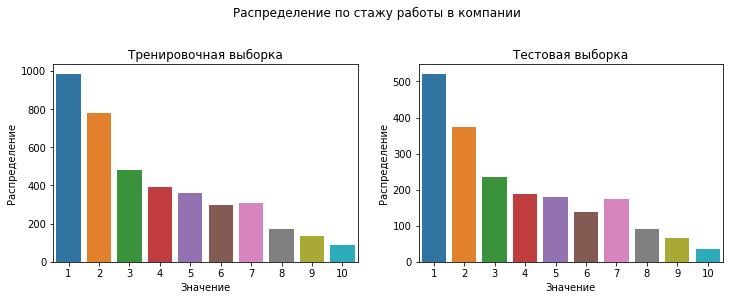

____________________________________________________________________________________________________


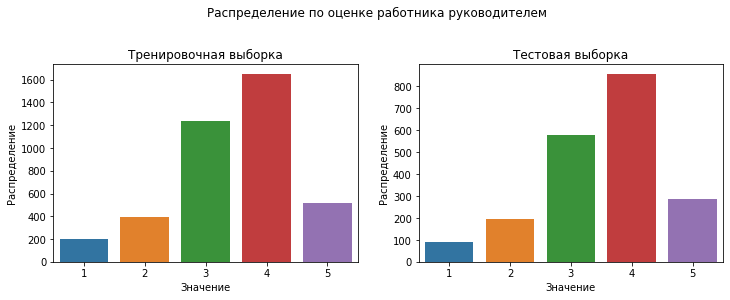

____________________________________________________________________________________________________


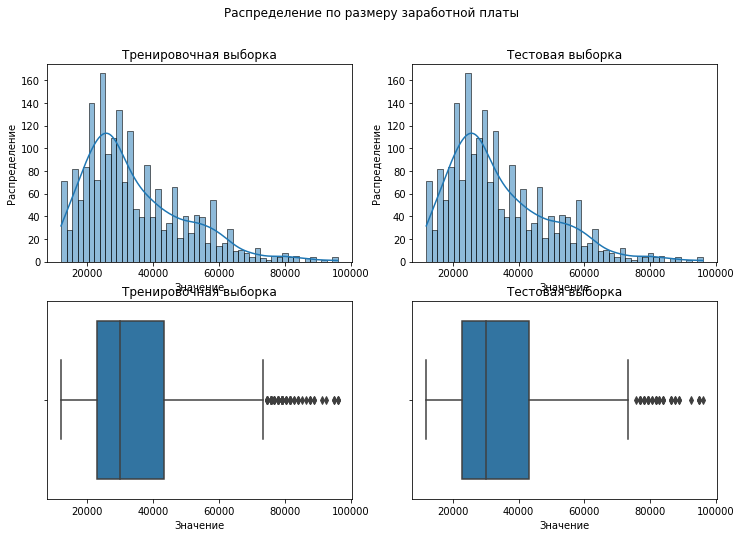

____________________________________________________________________________________________________


In [ ]:
# запустим цикл построения графиков для количественных данных
for p in train_quit.select_dtypes('number').columns:
    if p in discrete_list:
        disc_plot(train_quit,
                  'Тренировочная выборка',
                  test_features_2,
                  'Тестовая выборка',
                  p,
                  f'Распределение по {subs.get(p)}',
                  'Значение',
                  'Распределение')
    else:
        quant_plot(train_quit[p],
                   'Тренировочная выборка',
                   test_features_2[p],
                   'Тестовая выборка',
                   f'Распределение по {subs.get(p)}',
                   'Значение',
                   'Распределение')
    print ('_'*100)

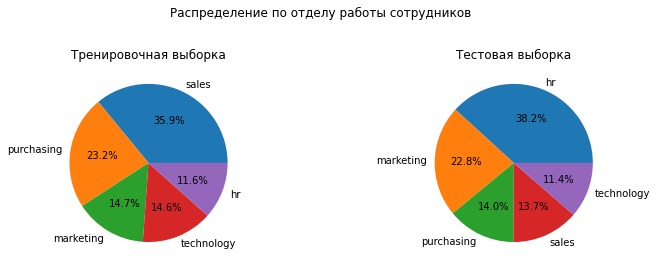

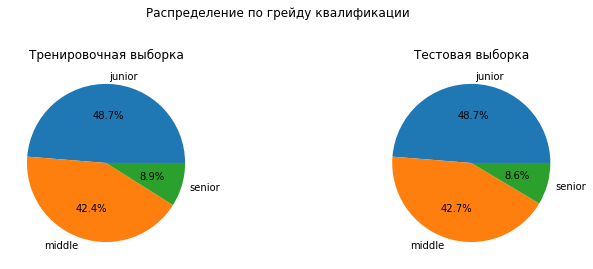

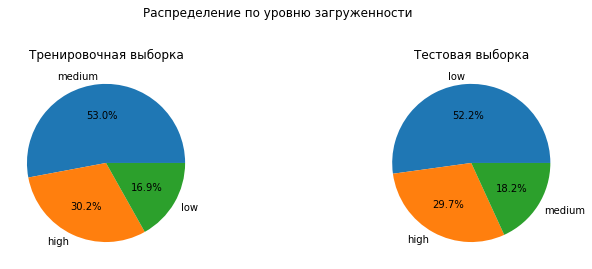

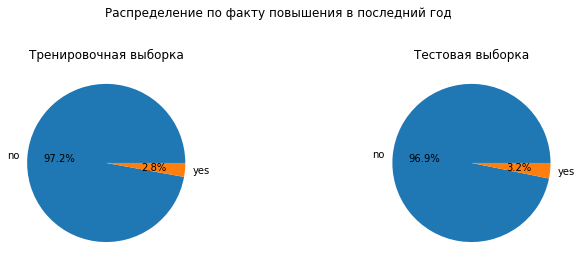

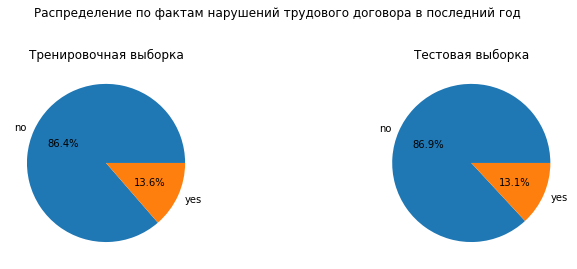

In [ ]:
# запустим цикл построения графиков для качественных данных
for p in train_quit.drop(['quit'],axis=1).select_dtypes('object').columns:
    cat_plot(train_quit[p].dropna(),
            'Тренировочная выборка',
            test_features_2[p].dropna(),
            'Тестовая выборка',
            f'Распределение по {subs.get(p)}')

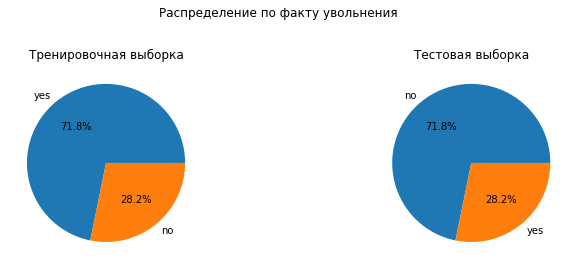

In [ ]:
# выведем графики для выборок с целевым признаком
s2 = 'quit'
cat_plot(train_quit[s2],
         'Тренировочная выборка',
         test_target_2[s2],
         'Тестовая выборка',
         f'Распределение по {subs.get(s2)}')

При оценке количественных данных, видим  картину аналогичную предыдущей задаче что:

 - распределение по стажу работы в компании также нисходящее от 1 до 10, с небольшим пиком на 7 летней отметке в тестовой выборке и увеличенным количеством на 6 летней отметке в тренировочной выборке
 - распределение по оценке руководителем в основной массе варьируется между оценками 3 и 4, с пиком на оценке 4 и картина в тренировочной выручке немного отличается от тестовой в значениях 3.
 - по размеру заработной платы распределения в тренировочной и тестовой выборках идентичные, незначительне отличия есть только в выбросах, что не сильно критично;

При оценке качественных данных, видим, что:

 - картина распределения по отделам работы сотрудников в снова отличается пропорциями отдельных отделов:
      - в тренировочной выборке наибольшая доля сотрудников из отдела продаж, а в тестовой из отдела HR
      - второе место в тренировочной выборке занимает отдел закупок, в том время как в тестовой маркетинг
      - третье место в тренировочной выборке с долей занимает маркетинг, в тестовой - закупки
      - четвертое место в тренировочной выборке занимает технологический блок, а в тестовой продажи
      - наименьшую долю в тренировочной выборке занимает HR, а в тестовой технологический блок
 - распределение по грейду сотрудников имеет небольшие отличия в целом, мы видим, что основную массу занимают джуны (48,7%)и мидлы ( ~42,5%)
 - по уровню загруженности, в тестовой выборке основную массу занимают сотрудники со средней загруженностью, а в тестовой с низкой. Среднюю позицию занимает высока нагрузка
 - распределение по фактам повышения сотрудников в тренировочной и тестовой выборках почти идентичны - в обеих выборках ~97% занимает доля сотрудников не получавших повышения.
 - распределение по фактам нарушения трудового договора в последний год тоже почти идентичное: 86-87% сотрудников в последний год не допускали нарушения трудового договора.
 - по целевому признаку - по фактам увольнения, распределение обратно пропорциональное, что в тренировочной выборке и тестовых выборках: в тренировочной уволившихся 71,8% и 28,2% работающих, в тестовой наоборот.

#### Корреляционный анализ

Для корреляционного анализа, как и в первой задаче посьтроим две матрицы:
 - первую для тренировочной выборки для выявления мультиколлинеарности и оценки корреляции между целевым признаком и входящими
 - вторую для выявления мультиколлинеарности в тестовой выборке

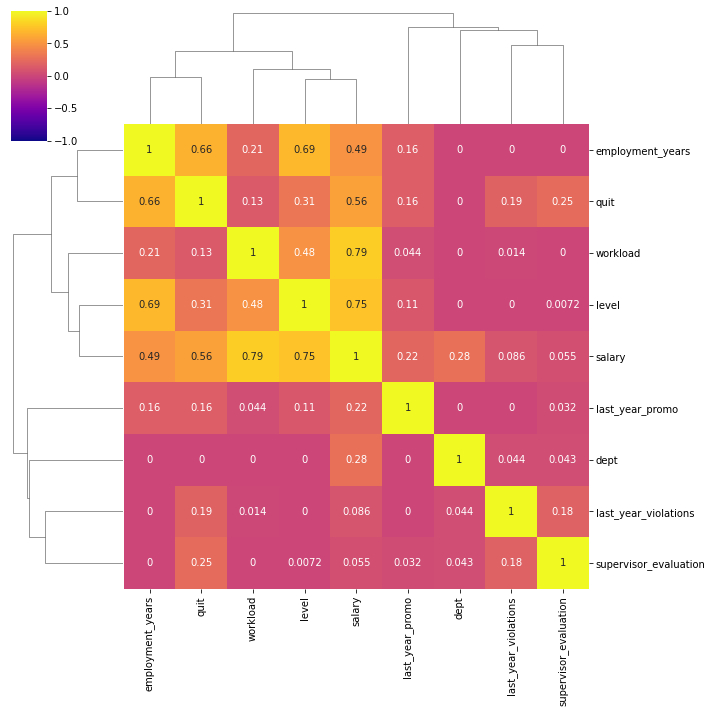

In [ ]:
# построим кластерную матрицу по итоговой таблице phik_matrix()
sns.clustermap(
    train_quit.phik_matrix(interval_cols=int_cols),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='plasma')

Аналогично первой задаче видим, что мультиколлинеарности нет, максимальный коэффициент корреляции 0,79.
Наибольшее влияние на целевой признак имеют следующие входящие признаки:
 - стаж работы в компании - 0,69
 - зарплата - 0,56
 - и небольшое влияние уровень грейда - 0,31
Из этого можно сделать вывод, что чем дольше работает сотрудник без повышения зарплаты и повышения грейда, тем выше риск его увольнения.

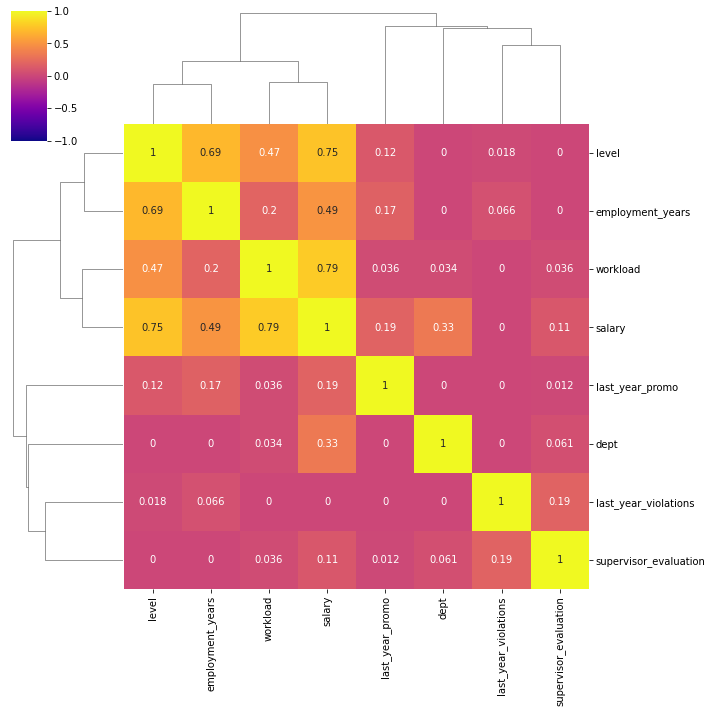

In [ ]:
# постоим кластерную матрицу для тестовой выборки
sns.clustermap(
    test_features_2.phik_matrix(interval_cols=int_cols),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='plasma')

В тестовой выборке видим отсутствие мульиколлинеарности, самый высокий показатель корреляции 0,79 между зарплатой и уровнем нагрузки и  0,75 между зарплатой и грейдом

#### Портрет уволившегося сотрудника

Немного изменим функции для построения графиков, так как нам не нужно сравнивать два показателя

In [ ]:
# функция построения графиков для количественных данных
def quant_plot_2(graf_data, subtitle, xlabel, ylabel):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    fig.suptitle(subtitle)

    plt.subplot (2, 2, 1)
    sns.histplot(graf_data, kde=True, bins=50)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.subplot (2, 2, 2)
    sns.boxplot(x=graf_data)
    plt.xlabel(xlabel)

    plt.show()

In [ ]:
# функция построения графиков для дискретных количественных данных
def disc_plot_2(graf_data, col, subtitle, xlabel, ylabel):
    sns.countplot(data=graf_data, x=col)
    plt.suptitle(subtitle)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
# функция построения графиков для качественных данных
def cat_plot(data, title):
    plt.pie(
        data.value_counts(),
        labels=data.unique(),
        autopct='%1.1f%%')
    plt.title(title)
    plt.grid()
    plt.show()

Построим графики для формирования портрета уволившихся

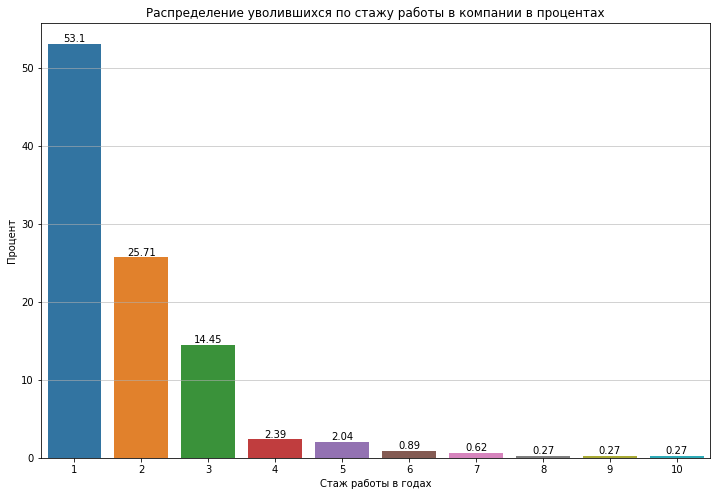

____________________________________________________________________________________________________


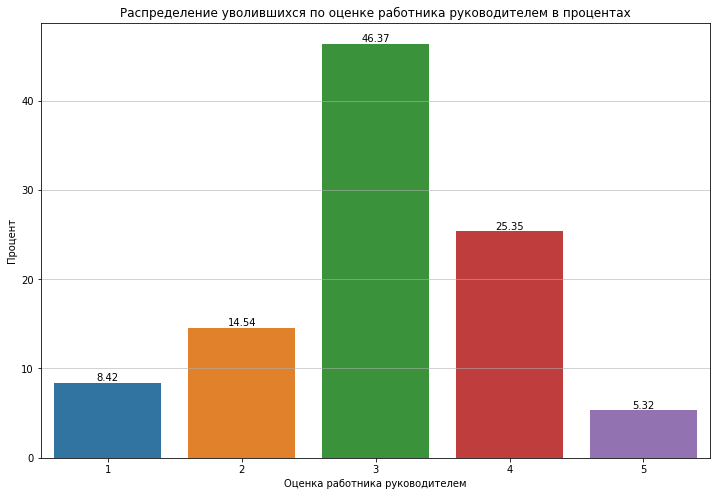

____________________________________________________________________________________________________


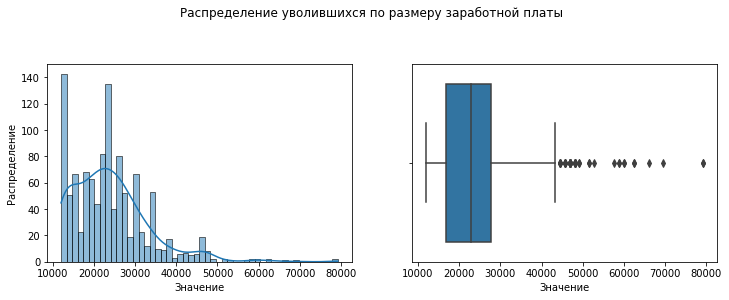

____________________________________________________________________________________________________


In [ ]:
# запустим цикл построения графиков для количественных данных
subs_disc= {'employment_years': 'Стаж работы в годах',
            'supervisor_evaluation': 'Оценка работника руководителем'}
for p in train_quit.query('quit == "yes"').select_dtypes('number').columns:
    if p in discrete_list:
        percent = (train_quit.query('quit == "yes"')[p].value_counts(normalize=True) * 100).round(2)
        bar_data = pd.DataFrame({'cat': percent.index, 'percent': percent.values})
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='cat', y='percent', data=bar_data)
        for container in ax.containers:
            ax.bar_label(container)
        plt.xlabel(f'{subs_disc.get(p)}')
        plt.ylabel('Процент')
        plt.title(f'Распределение уволившихся по {subs.get(p)} в процентах')
        plt.grid(axis='y', linestyle='-', alpha=0.7)
        plt.show()

    else:
        quant_plot_2(train_quit.query('quit == "yes"')[p],
                   f'Распределение уволившихся по {subs.get(p)}',
                   'Значение',
                   'Распределение')
    print ('_'*100)

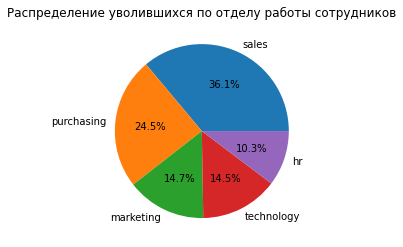

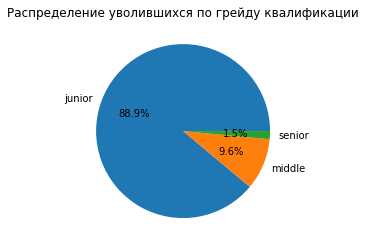

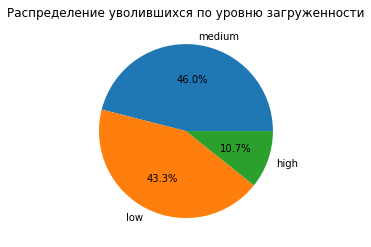

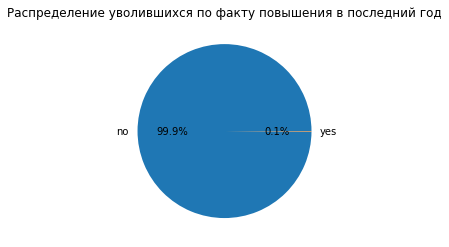

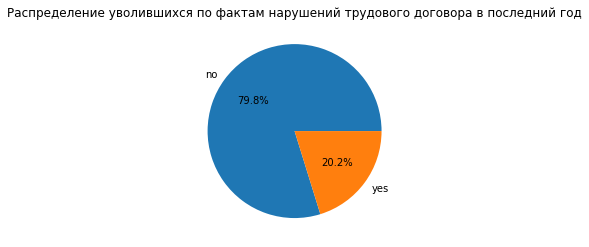

In [ ]:
# запустим цикл построения графиков для исследования портрета уволившегося сотрудника
for p in test_features_2.select_dtypes('object').columns:
    cat_plot(train_quit.query('quit == "yes"')[p].dropna(), f'Распределение уволившихся по {subs.get(p)}')

In [ ]:
# вывеедм информацию для сравнения средней зарплаты
train_quit.pivot_table(index = 'quit', values = 'salary', aggfunc = 'median')

,salary
quit,
no,34800
yes,22800


Исходя из полученных данных можно сформировать такой портрет уволившихся:
- большая часть уволившихся сотрудников работаю в компании не более 3 лет, основная масса не более 1 года;
- большая часть уволившихся сотрудников имеет оценку работы 3 и небольшая доля оценку 4;
- заработная плата уволившихся сотрулников не превышает 50 000 рублей, в основной массе это зарплата в диапазоне от 15 000 до 28 000 рублей. Средняя заработная плата уволившихся сотрудников приблизительно на 30% выше чем у продолжающих работать.
- большая часть уволившихся сотрудников имеет самый низкий грейд - джуны, 9,6% мидлы и лишь 1,5 процента сеньоры
- большая часть сотрудников имеет среднюю или низкую нагрузку
- почти все уволившиеся сотрудники не получали повышения в последний год
- основная масса сотрудников (около 80%) не допускали нарушения трудового договора

Итого вы видим, что в основной зоне риска отделы продаж и закупок. Традиционно именно в отделе продаж самая высокая текучка, особенно при условии сложной финансовой мотивации, когда сотрудник не видит результата своей работы и низка зарплата его не мотивирует. Основной инструмент работы с такими отделами - привязка ежемесячной премии к результатам работы - это позволяет мотивировать их более эффективно, в привязке к их результату работы. Кроме того, сама нагрузка для них недостаточно высокая, чтобы они могли показывать результат работы, из-за этого и низка оценка руководителем. Тем более что по большей части это линейный персонал - рядовые менеджеры, которые не успевают получить достаточно опыта для повышения грейда, то есть результат работы должен быть виден и привязан к финансовой мотивации в первый же год. К тому же большая часть вполне добросовестные сотрудники. Трудовые условия допускает лишь 1/5 сотрудников, видимо пытаясь этим компенсировать низкую финансовую мотивацию.

#### Распределение job_satisfaction_rate для уволившихся и работающих сотрудников

У нас в распоряжении есть гипотеза аналтиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник Мы должны проверить эту гипотезу.
Для начала проведем объединение целевых показателей из первой задачи и из второй.

In [ ]:
# сделаем сводную таблицу из целевых показателей задачи 1 и задачи 2
quit_merge = pd.merge(test_target_2, test_target, on='id', sort=True).sort_values(by='id')

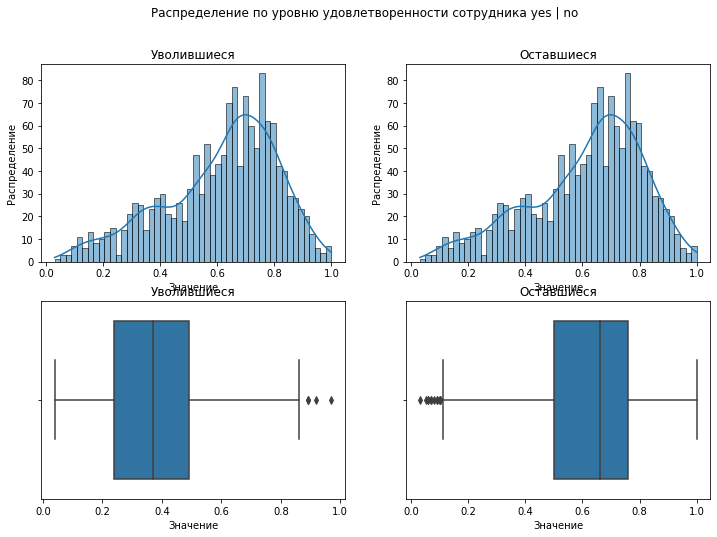

In [ ]:
# построим сравнительные графики c разделением по статусу увольнения
quant_plot(quit_merge[quit_merge[s2] == 'yes'][s],
           'Уволившиеся',
           quit_merge[quit_merge[s2] == 'no'][s],
           'Оставшиеся',
           f'Распределение по {subs.get(s)} yes | no',
           'Значение',
           'Распределение')

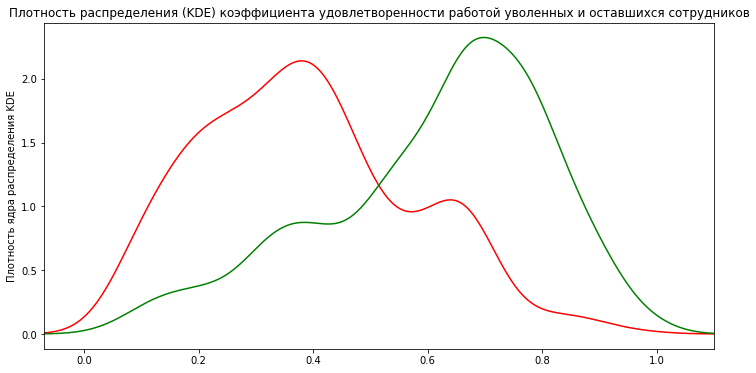

In [ ]:
# построим сравнительный график для распределения плотности KDE
plt.figure(figsize=(12,6))
plt.title('Плотность распределения (KDE) коэффициента удовлетворенности работой уволенных и оставшихся сотрудников')
plt.xlim (quit_merge['job_satisfaction_rate'].min()-0.1, quit_merge['job_satisfaction_rate'].max()+0.1)
ax = quit_merge[quit_merge['quit']=='yes']['job_satisfaction_rate'].plot.kde(color='red')
ax = quit_merge[quit_merge['quit']=='no']['job_satisfaction_rate'].plot.kde(color='green')
ax.set_ylabel('Плотность ядра распределения KDE')
plt.show()

Видим, что уровень удовлетворенности у сотрудников отличается, у уволившихся уровень удовлеворенности в основной массе варьируется от 0.21 до 0.5, в то время как у работающих основная масса в значениях от 0.5 до 0.78.
Одной из причин неудовлетворенноси как раз может быть низкая финансовая мотивация Но проверим сформированную гипотезу.
Распределение плотности ядра KDE также показывает, что у уволившихся в основной массе уровень удовлетворенности сильно ниже чем у оставшихся.

Сформируем гипотезы на основании вводных от аналитиков:
- H0: Средние значения совокупной выборки равны, а значит зависимости между увольнением и удовлетворенностью работой нет.
- H1: Средние значения совокупной выборки не равны, а значит есть зависимости между увольнением и удовлетворенностью работой.

In [ ]:
# проведем тестирование гипотез
quit = quit_merge[quit_merge['quit']=='yes']
not_quit = quit_merge[quit_merge['quit']=='no']

print(ttest_ind(quit['job_satisfaction_rate'], not_quit['job_satisfaction_rate']))
print(ttest_ind(quit['job_satisfaction_rate'], not_quit['job_satisfaction_rate'], equal_var= False ))

Ttest_indResult(statistic=-23.074784903634534, pvalue=1.231122066517193e-104)
Ttest_indResult(statistic=-23.795097591114747, pvalue=2.7708628031539788e-101)


Видим, что pvalue сильно меньше 0,05, а это значит, что мы отклоняем нулевую гипотезу t-критерия, то есть отклоняем нулевую гипотезу и тем самым подтверждаем, что между увольнением и удовлетворенностью есть зависимость.

#### Выводы по блоку

В процессе исследовательского анализа выбросов серьезно влияющих на обучене моделей мы не выявили, однако снова выявили несоответствие пропорций входных признаков в тренировочной выборке и в тестовой по отделам работы сотрудников уровню их трудовой загрузки и фактам увольнения, однако как и в первой задаче это не помешает обучению моделей предсказания.
При корреляционном анализе выявили отсутствие мультиколлинеарности между входными признаками и выявили признаки оказывающие наибольшее влияние на целевой признак.

При построении портрета уволившегося сотрудника, выявили, что чаще всего увольняются сотрудники первого года, чуть реже второго и третьего года работы, в основном из отделов продаж и закупок, вероятно из-за низкой финансовй мотиваци и невозможности продвинуться по карьерной лестнице в первый год работы, при этом их уровень удовлетворенности работой в компании значительно ниже, чем у оставшихся сотрудников.

Аналитиками была выдвинута гипотеза о зависимости между уровнем удовлетворенности работой и частостой увольнений. В процессе проверки гипотезы, мы подтвердили что такая зависимость есть.

### Добавление нового входного признака

#### Добавление нового признака и предобработка

На основании ранее обученной модели нам необходимо добавить к входным признакам новый признак - спрогнозированный уровень удовлетворености работой

In [ ]:
# добавим в тренировчный и тестовый датафреймы новый признак на основе предсказания
train_quit['job_satisfaction_rate'] = model.predict(train_quit)
test_features_2['job_satisfaction_rate'] = model.predict(test_features_2)
train_quit.info()
test_features_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 472.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 -----

Данные добавлены успешно, пропусков нет, построим новую марицу корреляции

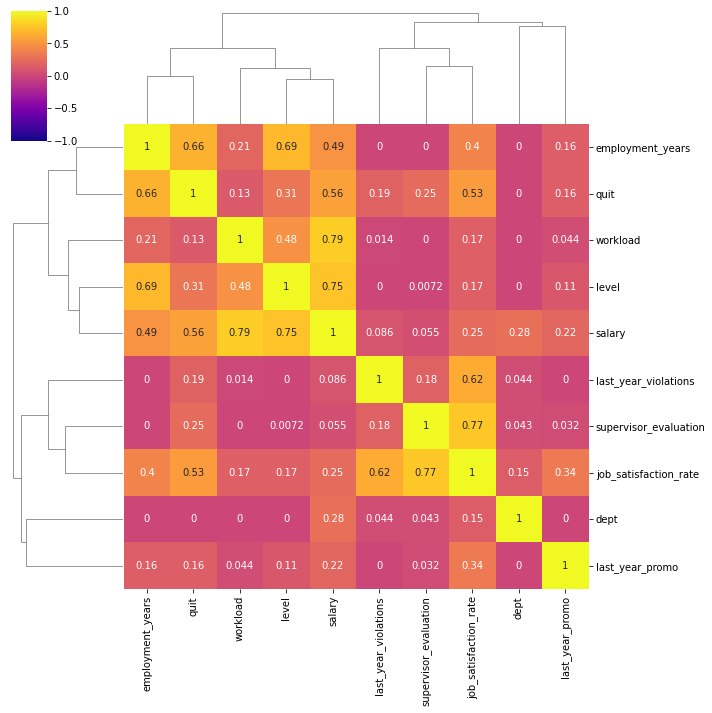

In [ ]:
# посторим кластерную матрицу на новой тренировочном датафрейме
sns.clustermap(
    train_quit.phik_matrix(interval_cols=int_cols),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='plasma')

После построения новой матрицы корреляции с новым входным признаком, видим, что мультиколлинеарность не появилась, наибольшее влиние на целевой признак по прежнему оказывают, стаж работы, зарплата и грейд, но к этим признакам добавился еще один - уровень удовлетворенности работой.

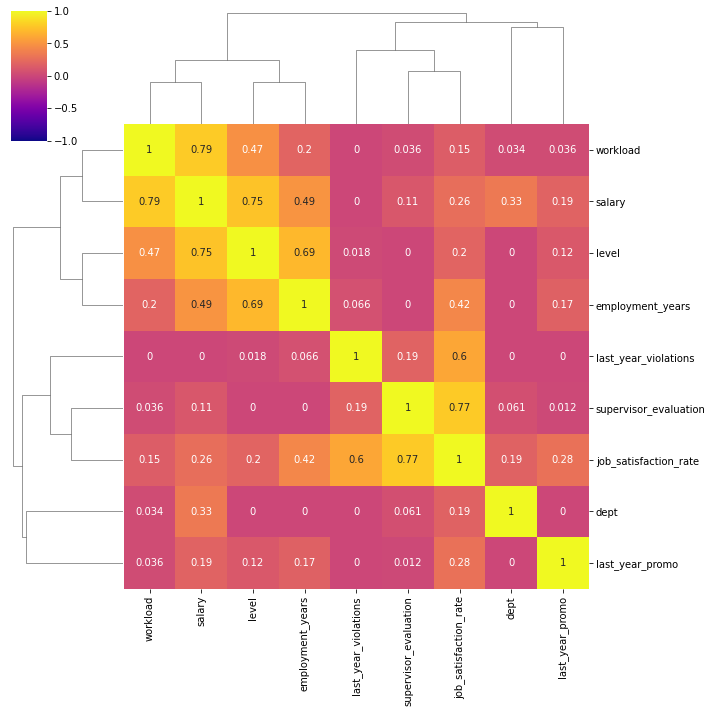

In [ ]:
# посторим кластерную матрицу на новом тестовом датафрейме
sns.clustermap(
    test_features_2.phik_matrix(interval_cols=int_cols),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='plasma')

Видим, что после добавления нового признака мультиколлинеарность  в тестовой выборке тоже не проявилась

#### Выводы по блоку

Для прогнозирования увольнения сотрудников, в тренировочную и тестовые выборки был добавлен новый признак - уровень удовлетворенности, на основании прогноза ранее обученной модели, поскольку ранее уже было подтверждено что этот признак оказывает влияние на целевой признак - факт увольнения сотрудника. После его добавления была построена матрица корреляции, которая подтвердила, что с добавлением нового признака мультиколлинеарность не появилась, хотя новый признак и попал в перчень оказывающих наибольшее влияние на целевой.

### Подготовка данных

#### Удаление дубликатов

Перед обучением необходимо удалить дубликаты, для повышения качества обучения

In [ ]:
# удалим дубликаты из тренировочной выборки
train_quit = train_quit.drop_duplicates()
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   quit                   2587 non-null   object 
 9   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 222.3+ KB


После удаления дубликатов, в тренировочной выборке осталось 2587 строк с данными

#### Подготовка данных

Перед разбивкой выборок проведем кодировку целевого признака

In [ ]:
# кодировка целевого признака
le = LabelEncoder()
le.fit_transform(train_quit['quit'].unique())
print ('Значениям', le.classes_, 'назначено', le.transform(le.classes_))
# трансформация целевого признака
train_quit['quit'] = le.transform(train_quit['quit'])
test_target_2['quit'] = le.transform(test_target_2['quit'])

Значениям ['no' 'yes'] назначено [0 1]


Снова, как и в прошлой задаче, на основании имеющихся выборок создадим выборки для обучения.

In [ ]:
# запишем выборки для обучения на основании датафреймов
X_train_2 = train_quit.drop('quit', axis=1)
y_train_2 = train_quit['quit']
X_test_2 = test_features_2
y_test_2 = test_target_2['quit']

Добавим в список числовых колнок еще одно значение - 'job_satisfaction_rate'

In [ ]:
# добавим новове название входного признака
num_columns.append("job_satisfaction_rate")
num_columns

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

Поскольку у нас изменился набор колонок для кодировки, необходимо переопределить препроцессор

In [ ]:
# обновим препроцессор
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

Пересоберем финальный пайплайн с учетом задачи классификации

In [ ]:
# соберем новый финальный пайплайн
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, probability=True))
])

#### Выводы по блоку

В процессе подготовки данных для обучения, были проведены следующие операции:
 - целевой признак кодирован с помощью LabelEncoder
 - из тренировочной выборки веделен целевой признак, сама трерировочная выборка от него очищена, для обучения второй модели в отдельные переменные выделены тренировочные и тестовые показатели
 - новые пайплайны для кодирования разных типов данных не собирались, использовались ранее собранные
 - из-за нового входного признака были пересобраны препроцессор и финальный пайплайн под задачу классификации

### Обучение модели

Запишем 2-й набор параметров для перебора моделей для обучения с учетом задачи классификации

In [ ]:
# запишем сетку гиперпараметров для второй модели
param_grid_2 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__criterion': ['gini', 'entropy', 'log_loss'],
        'models__splitter': ['best', 'random'],
        'models__max_depth': [None] + [i for i in range(2, 20)],
        'models__min_samples_split': range(2, 42),
        'models__min_samples_leaf': range(2, 10),
        'models__max_leaf_nodes': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [ ]:
# обучим вторую модель
model_2 = RandomizedSearchCV(
    pipe_final_2,
    param_grid_2,
    cv=5,
    n_iter=50,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
# выводим лучшую модель и ее параметры
model_2.fit(X_train_2, y_train_2)
print('Лучшая модель и её параметры:\n\n', model_2.best_estimator_)
# выводим значение метрики лучшей модели на кросс-валидации
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', model_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Выведем график значимости входных признаков

In [ ]:
# запишем лучшую модель
best_model = model.best_estimator_
best_preprocessor = model.best_estimator_.named_steps['preprocessor']

In [ ]:
# запишем трансформеры
X_train_trans = pd.DataFrame(best_preprocessor.transform(X_train_2), columns=best_preprocessor.get_feature_names_out())
X_train_trans = X_train_trans.sample(frac=0.10, replace=True, random_state=RANDOM_STATE) # выборка из 10% случайных записей
X_test_trans = pd.DataFrame(best_preprocessor.transform(X_test_2), columns=best_preprocessor.get_feature_names_out())
X_test_trans = X_test_trans.sample(frac=0.10, replace=True, random_state=RANDOM_STATE) # выборка из 10% случайных записей
# сокращение выборок до 10% необходимо для увеличения скорости обработки данных

In [ ]:
# подготовим данные на отобранных выборках для сокращения
explainer = shap.KernelExplainer(best_model.named_steps['models'].predict, X_train_trans)
shap_values = explainer.shap_values(X_test_trans)

Using 259 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

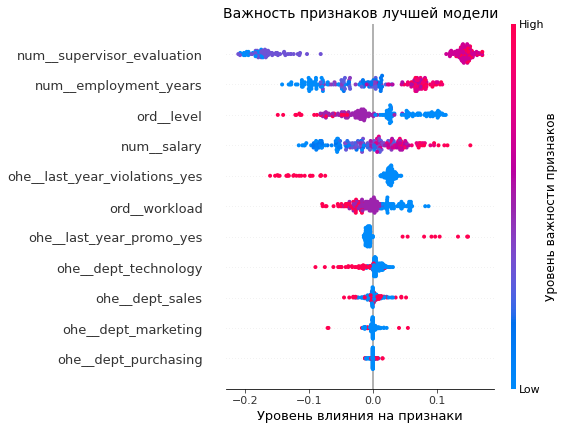

In [ ]:
# выведем график важности признаков
shap.summary_plot(shap_values, X_test_trans, show=False)

fig, ax = plt.gcf(), plt.gca()
ax.set_title('Важность признаков лучшей модели', fontsize=14)
ax.set_xlabel('Уровень влияния на признаки')
cb_ax = fig.axes[1]
cb_ax.set_ylabel('Уровень важности признаков')

plt.show()

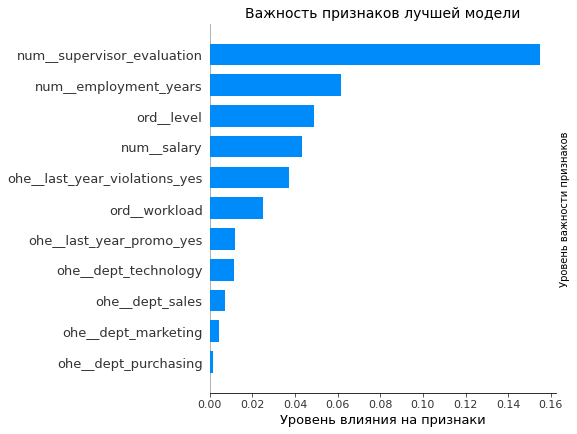

In [ ]:
# выведем график важности признаков гистограммой
shap.summary_plot(shap_values, X_test_trans, plot_type='bar', show=False)

fig, ax = plt.gcf(), plt.gca()
ax.set_title('Важность признаков лучшей модели', fontsize=14)
ax.set_xlabel('Уровень влияния на признаки')
cb_ax = fig.axes[0]
cb_ax.yaxis.set_label_position("right")
cb_ax.set_ylabel('Уровень важности признаков')

plt.show();

Видим, что на лучшую модель наибольшее влияние оказывает оценка руководителем (ранее о этом уже говорили), а принадлежность к разным отделам наименьшее влияние

In [ ]:
# проверим модель на адекватность
dummy_class = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_class.fit(X_train_2, y_train_2)

roc_auc_test = roc_auc_score(y_test_2, model_2.predict_proba(X_test_2)[:, 1])
print(f'ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_test, 3)}')
roc_auc_test = roc_auc_score(y_test_2, dummy_class.predict_proba(X_test_2)[:, 1])
print(f'Значение ROC-AUC модели DummyClassifier на тестовой выборке: {round(roc_auc_test, 3)}')

ROC-AUC лучшей модели на тестовой выборке: 0.925
Значение ROC-AUC модели DummyClassifier на тестовой выборке: 0.501


In [ ]:
# запишем параметры лучшей модели и выведем на экран
top_model_2 = pd.DataFrame(model_2.cv_results_).sort_values(by=['rank_test_score'])
top_model_2[['rank_test_score', 'param_models', 'params']].head(1)

,rank_test_score,param_models,params
1,1,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__splitter': 'best', 'models__min_samples_split': 40, 'models__min_samples_leaf': 4, 'models__max_leaf_nodes': 18, 'models__max_depth': 19, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}"


### Выводы по итогу задачи

По итогу обучения модели предсказания:
- из четырех моделей классификации, лучшей моделью признана модель деревьев решений (DecisionTreeClassifier) с параметрами: {'preprocessor__num': 'passthrough', 'models__splitter': 'best', 'models__min_samples_split': 40, 'models__min_samples_leaf': 4, 'models__max_leaf_nodes': 18, 'models__max_depth': 19, 'models__criterion': 'log_loss';
- метрика ROC-AUC обученной модели показываеn на тестовой выборке 0.925 что, в соответствии с условиями задачи соответствует критериями успеха (>= 0.91 на тестовой выборке);
- при проверке модели на адекватность с помощью модели Classifier, видим, что наш результат значительно выше константного, а значит модель работает правильно;

В дальнейшем, для прогнозирования риска увольнения сотрудника, можно использовать обученную нами модель.

#### Выводы по блоку

## Общие выводы

**Общий вывод**

По условиям задачи, необходимо было разработать два решения, которые HR-аналитикам компании «Работа с заботой» помогут оптимизировать управление персоналом:
1. Модель предсказания уровня удовлетворенности работой у сотрудников
2. Модель предсказания риска увольнения сотрудников

Для разработки решений были предоставлены для каждой задачи:
 - тренировочная выборка с входящими и целевым признаком
 - тестовая выборка с входящими признаками
 - тестовая выборка с ключевым признаком

**Работа по Задаче 1 состояла из следующих этапов:**

1. Загрузка данных;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Подготовка данных;
5. Обучение модели;

<h3>Задача 1</h3>

<h4>Загрузка данных</h4>
При загрузке и изучении данных было выявлено, что в целом данные пригодны для анализа, были выявлены пропуски и ошибки в данных.

<h4>Предобработка данных</h4>
В ходе предобработки данных были проведены следующие операции:
 - исправлены ошибки в написании грейда senior
 - пустые значения ' ' заменены на пропуски nan
 - проведена проверка корректности разделения тестовой и тренировочной выборок на пересечения по id
 - id переведены в индексы и отсортированы
 - по итогу изучения пропусков принято решение их заполнить в паплайне с помощью SimpleImputer

<h4>Исследовательский анализ данных</h4>
В процессе исследовательского анализа выбросов серьезно влияющих на обучене моделей не выявлено, однако выявили несоответствие пропорций входных признаков в тренировочной выборке и в тестовой по отделам работы сотрудников и уровню их трудовой загрузки. Кроме того при корреляционном анализе выявили отсутствие мультиколлинеарности между входными признаками и выявили признаки оказывающие наибольшее влияние на целевой признак.

<h4>Подготовка данных</h4>
В процессе подготовки данных для обучения, были проведены следующие операции:
 - Из тренировочной выборки веделен целевой признак, сама трерировочная выборка от него очищена, для обучения первой модели в отдельные переменные выделены тренировочные и тестовые показатели
 - собраны пайплайны для кодирования разных типов данных:
     - категорийные данные из колонок 'dept' - отдел работы сотрудника 'last_year_promo' - факт повышения в последний год и 'last_year_violations' - факт нарушения трудового договора в последний год, кодированы с помощью кодировщика OneHotEncoder, пропуски заполнены с помощью SimpleImputer наиболее популярными значениями;
     - порядковые категорийныйе данные из колонок 'level' - грейд работника и 'workload' - рабочая нагрузка работника, кодированы с помощью кодировщика OrdinalEncoder, пропуски также заполнены с помощью SimpleImputer наиболее популярным значениями.
 - числовые значения масштабированы с помощью RobustScaler робастными из-за наличия выбросов;
 - проведена трансформация тренировочной и тестовой выборок

<h4>Обучение модели</h4>
По итогу обучения модели предсказания:
 - из двух вариантов моделей - Линейной регрессии и Древьев решений, лучшей моделью признана модель деревьев решений (DecisionTreeRegressor) с параметрами: preprocessor__num': RobustScaler(), 'models__min_samples_split': 8, 'models__min_samples_leaf': 1, 'models__max_depth': 27;
 - метрика SMAPE обученной модели показывает 13,6% что, в соответствии с условиями задачи соответствует критериями успеха (<= 15%);
 - при проверке модели на адекватность с помощью модели DummyRegressor, видим, что наш результат значительно ниже константного, а значит модель работает правильно;

В дальнейшем, для прогнозирования уровня удовлетворенности работой сотрудника, можно использовать обученную нами модель.

**Работа по Задаче 2 состояла из следующих этапов:**

1. Загрузка данных;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Добавление нового входящего признака;
5. Подготовка данных;
6. Обучение модели;

<h3>Задача 2</h3>

<h4>Загрузка данных</h4>
При загрузке и изучении данных было выявлено, что в целом данные пригодны для анализа, снова были выявлены пропуски и ошибки в данных.

<h4>Предобработка данных</h4>
В ходе предобработки данных были проведены следующие операции:

 - исправлены ошибки в написании грейда senior
 - пустые значения ' ' заменены на пропуски nan
 - проведена проверка корректности разделения тестовой и тренировочной выборок на пересечения по id
 - id переведены в индексы и отсортированы
 - явные пропуски решено снова заполнить в паплайне с помощью SimpleImputer

<h4>Исследовательский анализ данных</h4>
В процессе исследовательского анализа выбросов серьезно влияющих на обучене моделей не выявлено, однако снова выявили несоответствие пропорций входных признаков в тренировочной выборке и в тестовой по отделам работы сотрудников уровню их трудовой загрузки и фактам увольнения, однако как и в первой задаче это не помешает обучению моделей предсказания. При корреляционном анализе выявили отсутствие мультиколлинеарности между входными признаками и выявили признаки оказывающие наибольшее влияние на целевой признак.

При построении портрета уволившегося сотрудника, выявили, что чаще всего увольняются сотрудники первого года, чуть реже второго и третьего года работы, в основном из отделов продаж и закупок, вероятно из-за низкой финансовй мотиваци и невозможности продвинуться по карьерной лестнице в первый год работы, при этом их уровень удовлетворенности работой в компании значительно ниже, чем у оставшихся сотрудников.

Аналитиками была выдвинута гипотеза о зависимости между уровнем удовлетворенности работой и частостой увольнений. В процессе проверки гипотезы, подтверждено, что такая зависимость есть

<h4>Добавление нового входного признака</h4>
Для прогнозирования увольнения сотрудников, в тренировочную и тестовые выборки был добавлен новый признак - уровень удовлетворенности, на основании прогноза ранее обученной модели, поскольку ранее уже было подтверждено что этот признак оказывает влияние на целевой признак - факт увольнения сотрудника. После его добавления была построена матрица корреляции, которая подтвердила, что с добавлением нового признака мультиколлинеарность не появилась, хотя новый признак и попал в перчень оказывающих наибольшее влияние на целевой.

<h4>Подготовка данных</h4>
В процессе подготовки данных для обучения, были проведены следующие операции:
 - целевой признак кодирован с помощью LabelEncoder
 - из тренировочной выборки веделен целевой признак, сама трерировочная выборка от него очищена, для обучения второй модели в отдельные переменные выделены тренировочные и тестовые показатели
 - новые пайплайны для кодирования разных типов данных не собирались, использовались ранее собранные
 - из-за нового входного признака были пересобраны препроцессор и финальный пайплайн под задачу классификации

<h4>Обучение модели</h4>
По итогу обучения модели предсказания:
- из четырех моделей классификации, лучшей моделью признана модель деревьев решений (DecisionTreeClassifier) с параметрами: {'preprocessor__num': 'passthrough', 'models__splitter': 'best', 'models__min_samples_split': 40, 'models__min_samples_leaf': 4, 'models__max_leaf_nodes': 18, 'models__max_depth': 19, 'models__criterion': 'log_loss';
- метрика ROC-AUC обученной модели показываеn на тестовой выборке 0.925 что, в соответствии с условиями задачи, соответствует критериями успеха (>= 0.91 на тестовой выборке);
 - при проверке модели на адекватность с помощью модели Classifier, видим, что наш результат значительно выше константного, а значит модель работает правильно;

В дальнейшем, для прогнозирования риска увольнения сотрудника, можно использовать обученную модель.

# Рекомендации

В ходе проведенной работы и анализа данным, выявлены ряд проблем на которые необходимо обратить внимание:
 - текущая модель материальной мотивации сотрудников отделов продаж и закупок является одной из основных причин текучки в компании: низкие зарплаты, низкая нагрузка и требует пересмотра. Рекомендуется внедрить систему мотивации позволяющую сотрудникам самим выбирать нагрузку, а систему оплаты труда сделать зависимой от нагрузки и финансового результата, с премированием. Это позволит избежать текучки и стимулировать молодых сотрулников дольше задерживаться в компании. Дополнительно стоит внедрить и систему нематериальной мотивации, но для измерения ее эффективности необходимо внедрять дополнительные метрики.
 - необходимо провести работу с руководящим составом по правилам предоставления обратной связи линейным сотрудникам, так как в первый год большое количество негативной обратной связи приводит к снижению удовлетворенности и повышению рисков увольнения
 - стоит пересмотреть систему повешения грейда сотрудникам, сделав ее более прозрачной, понятной, чтобы сотрудник понимали что им необходимо для повышения - это позволит и избежать текучки и стимулирует сотрулников дольше работать в компании